In [1]:
# https://dataframes.juliadata.org/stable/man/getting_started/

In [8]:
# Load installed packages
using DataFrames
using CSV
using Plots
using Lathe
using GLM
using Statistics
using StatsPlots
using MLBase

In [39]:
# Load data
df = DataFrame(CSV.File("data/sine440.csv"))
first(df, 5)

,onset,duration,sample_rate,amplitude,phase,frequency,decay,d
,Int64,Int64,Int64,Float64,Float64,Float64,Float64,String
1,0,250,44100,5.25153e-5,2.73962,21534.9,-20.0992,(-4.8329368041734524e-05+2.0545714446678468e-05j)
2,0,250,44100,5.25153e-5,-2.73962,-21534.9,-20.0992,(-4.8329368041734524e-05-2.0545714446678468e-05j)
3,0,250,44100,0.000100237,3.07657,21293.7,-68.687,(-0.00010002537988658094+6.513243716127503e-06j)
4,0,250,44100,0.000100237,-3.07657,-21293.7,-68.687,(-0.00010002537988658094-6.513243716127503e-06j)
5,0,250,44100,0.000108543,3.05488,21929.4,-109.194,(-0.00010813549037133643+9.400643557201682e-06j)


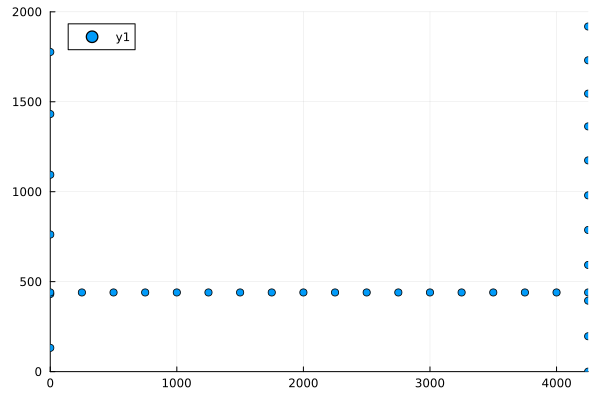

In [40]:
x = df.onset
y = df.frequency

plot(x , y, seriestype=:scatter, ylims = (0,2000), xlims = (0, maximum(x))) # a lot of noise at onset 0 and max(onset)

# Preprocessing

## Outlier/noise removal

In [41]:
# remove first and last frequency with noise
df = df[(df.onset .!= 0) .& (df.onset .!= maximum(x)), :]

,onset,duration,sample_rate,amplitude,phase,frequency,decay
,Int64,Int64,Int64,Float64,Float64,Float64,Float64
1,250,250,44100,0.499908,-1.53518,440.0,-1.79362e-5
2,250,250,44100,0.499908,1.53518,-440.0,-1.79362e-5
3,500,250,44100,0.499908,-1.64203,-440.0,2.93318e-6
4,500,250,44100,0.499908,1.64203,440.0,2.93318e-6
5,750,250,44100,4.17101e-5,-2.136,20169.0,-7.60292
6,750,250,44100,4.17101e-5,2.136,-20169.0,-7.60292
7,750,250,44100,0.499908,1.46394,-440.0,4.83648e-5
8,750,250,44100,0.499908,-1.46394,440.0,4.83648e-5
9,1000,250,44100,0.499909,-1.71327,-440.0,2.39577e-6


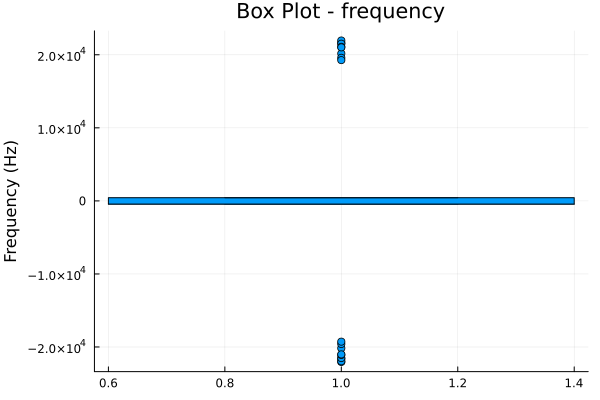

In [57]:
# Boxplot for outliers, notice: no outliers in complex space
boxplot(df.frequency, title = "Box Plot - frequency", ylabel = "Frequency (Hz)", legend = false)

In [58]:
first_percentile - 1.5*iqr_value

-1760.0000843254925

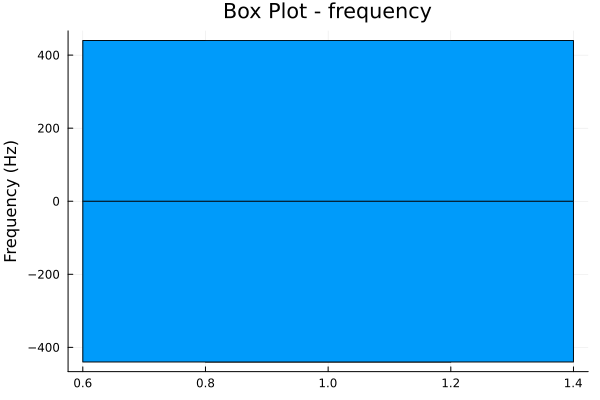

In [85]:
# Outlier removal
first_percentile = abs(percentile(df.frequency, 80)) # ensure always positive, 80% of the data closest to median

df_noNoise = df[(df.frequency .> -first_percentile-10) .& (df.frequency .< first_percentile+10),:]

boxplot(df_noNoise.frequency, title = "Box Plot - frequency", ylabel = "Frequency (Hz)", legend = false)


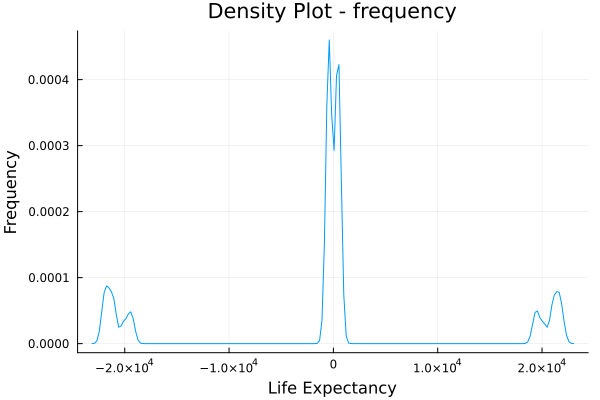

In [86]:
density(df.frequency , title = "Density Plot - frequency", ylabel = "Frequency", xlabel = "Life Expectancy", legend = false)

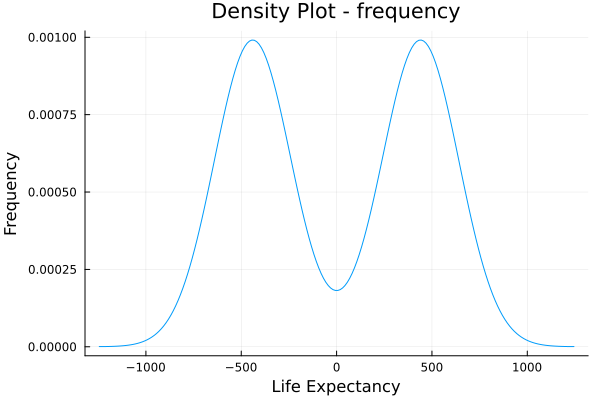

In [87]:
density(df_noNoise.frequency , title = "Density Plot - frequency", ylabel = "Frequency", xlabel = "Life Expectancy", legend = false)

# Linear regression

In [89]:
# Fit a line for the data (linear regression)

# Train test split
train, test = TrainTestSplit(df_noNoise,.75)

(23×10 DataFrame
 Row │ onset  duration  sample_rate  amplitude  phase     frequency  decay     ⋯
     │ Int64  Int64     Int64        Float64    Float64   Float64    Float64   ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │   250       250        44100   0.499908  -1.53518      440.0  -1.79362e ⋯
   2 │   500       250        44100   0.499908  -1.64203     -440.0   2.93318e
   3 │   750       250        44100   0.499908   1.46394     -440.0   4.83648e
   4 │   750       250        44100   0.499908  -1.46394      440.0   4.83648e
   5 │  1000       250        44100   0.499909  -1.71327     -440.0   2.39577e ⋯
   6 │  1250       250        44100   0.499909  -1.3927       440.0  -2.84349e
   7 │  1500       250        44100   0.499909   1.78451      440.0  -1.36656e
   8 │  1500       250        44100   0.499909  -1.78451     -440.0  -1.36656e
  ⋮  │   ⋮       ⋮           ⋮           ⋮         ⋮          ⋮           ⋮    ⋱
  17 │  3000       250 

In [ ]:
# ignore complex values (neg frequencies)

In [90]:
fm = @formula(onset ~ frequency)
linearRegressor = lm(fm, train)

# P value should be < 0.05 = check
# t value : the bigger, the better
# R square: the thigher, the better
r2(linearRegressor) # bad

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

onset ~ 1 + frequency

Coefficients:
─────────────────────────────────────────────────────────────────────────────
                   Coef.  Std. Error     t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────
(Intercept)  2117.42      233.582     9.06    <1e-07  1631.66      2603.19
frequency       0.111915    0.530869  0.21    0.8351    -0.992088     1.21592
─────────────────────────────────────────────────────────────────────────────

0.0021118396350495727

In [65]:
# Cleanup data: remove values with onset 0 and maximum onset (noise)
using Chakra #, Charm
push!(LOAD_PATH, "./src/")
using Resonances
include("./src/Flute.jl")


Main.Flute

In [66]:
# min = Flute.Resonances.sliceId(0)
# max = Flute.Resonances.sliceId(100)

# something = Resonances.getSlice(min, max, Flute) 